### imports

In [108]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from functools import reduce
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from six.moves import cPickle as pickle
from six.moves import range

from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten
from keras.utils import np_utils
from keras.optimizers import SGD

%matplotlib inline

import tensorflow as tf

### file loading and formatting

In [6]:
files = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5',
    'test_batch'
]

data = []
labels = []
start = time.time()
for file in files:
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        if file == 'test_batch':
            test_data = d[b'data']
            test_labels = d[b'labels']
        else:
            data.append(d[b'data'])
            labels.append(d[b'labels'])
end = time.time()
print('Time to load data: {:.3f}s'.format(end - start))
for i in range(len(data)):
    print('Train data {}:'.format(i), data[i].shape, len(labels[i]))
print('Test data:', test_data.shape, len(test_labels))

merged_data = reduce(lambda a,b: np.vstack((a,b)), data)
merged_labels = reduce(lambda a,b: a+b, labels)
print('Merged train data:', merged_data.shape, len(merged_labels))

Time to load data: 0.271s
Train data 0: (10000, 3072) 10000
Train data 1: (10000, 3072) 10000
Train data 2: (10000, 3072) 10000
Train data 3: (10000, 3072) 10000
Train data 4: (10000, 3072) 10000
Test data: (10000, 3072) 10000
Merged train data: (50000, 3072) 50000


### visualize a few of the images

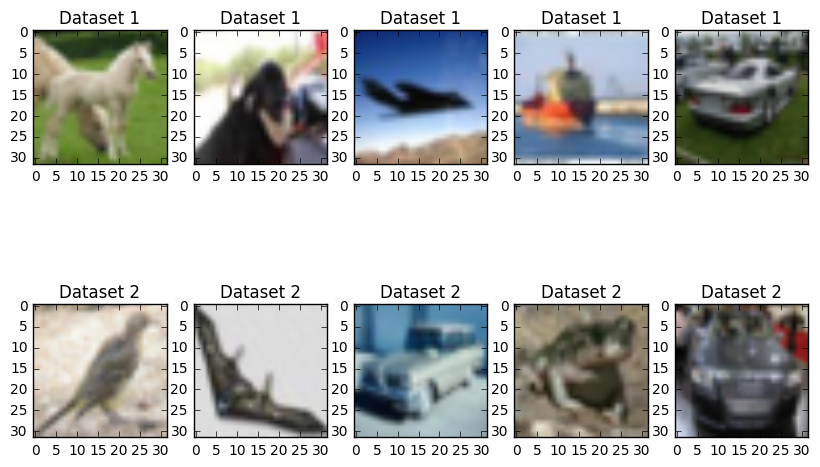

In [302]:
import matplotlib.image as mpimg

# used a batch size to speed up testing, but can easily change this to full dataset
batch_size = 1000

# random indices into the datasets so we can compare the same images across distortions
i_1 = np.random.choice(batch_size, 5)
i_2 = np.random.choice(batch_size, 5)

# basically the code from class, the images are stretched a lot but I don't think we'll
# be able to see the distortions if we view them at their actual size of 32x32 pixels
def show_images(num, i_1, dataset_1, i_2=None, dataset_2=None):
    fig1 = plt.figure(figsize=(10, 10))
    plt.gray()

    for k in range(num):
        i = i_1[k]
        if len(dataset_1.shape) == 2:
            img = np.reshape(dataset_1[i, :], (3, 32, 32)).transpose(1,2,0)
        else:
            assert(len(dataset_1.shape) == 4)
            img = dataset_1[i, :, :, :]
        imgplot1 = fig1.add_subplot(3,5,k+1)
        imgplot1.imshow(img)    
        imgplot1.set_title("Dataset 1", fontsize=12)
    
    if dataset_2 is not None:
        for k in range(num):
            i = i_2[k]
            if len(dataset_2.shape) == 2:
                img = np.reshape(dataset_2[i, :], (3, 32, 32)).transpose(1,2,0)
            else:
                assert(len(dataset_2.shape) == 4)
                img = dataset_2[i, :, :, :]
            imgplot2 = fig1.add_subplot(3,5,k+6)
            imgplot2.imshow(img)    
            imgplot2.set_title("Dataset 2", fontsize=12)
    
    plt.show()

show_images(5, i_1, merged_data, i_2, test_data)

### apply distortions

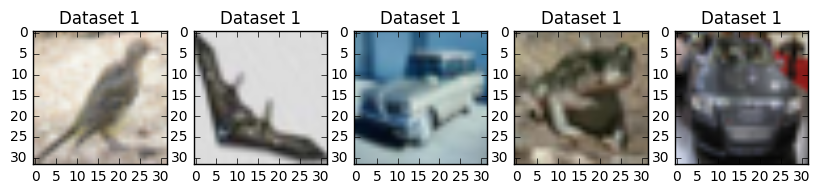

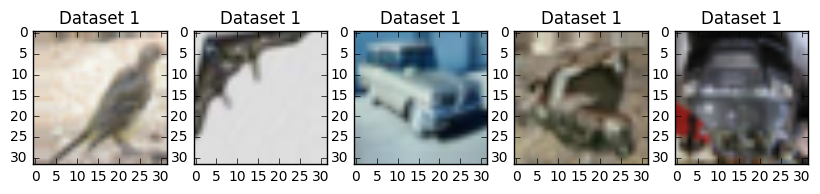

Time to run: 0.337s


In [324]:
from keras.preprocessing.image import ImageDataGenerator

# at some point when it's not 3am here I'll move this code down to after the reformatting
# but I couldn't get it to work earlier before I realized the section code was wrong
temp_data = 255-test_data.reshape(-1,3,32,32).transpose(0,2,3,1)
temp_labels = np_utils.to_categorical(test_labels, 10)

# all the subtracting from 255 is because the image processing tool seems to invert the
# colors even if we apply no distortions
show_images(5, i_2, 255-temp_data)

start = time.time()
# there are many options for the distortions we can do with this image processing tool
datagen = ImageDataGenerator(
    width_shift_range=.1,   # randomly shifts some images 10% horizontally
    height_shift_range=.1,  # randomly shifts some images 10% vertically
    horizontal_flip=True,   # randomly flips some images horizontally
    vertical_flip=True      # randomly flips some images vertically
)
# datagen.fit(temp_data, seed=25)  # this only matters if we're using other specific parameters
for distorted_test_data, distorted_test_labels in datagen.flow(temp_data, temp_labels,
                                                            shuffle=False,
                                                            batch_size=batch_size,
                                                            seed=25):
    break  # it's an infinite generator and we just want 1 application of the distortions
end=time.time()

show_images(5, i_2, distorted_test_data)
print('Time to run: {:.3f}s'.format(end - start))

### dataset preprocessing

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


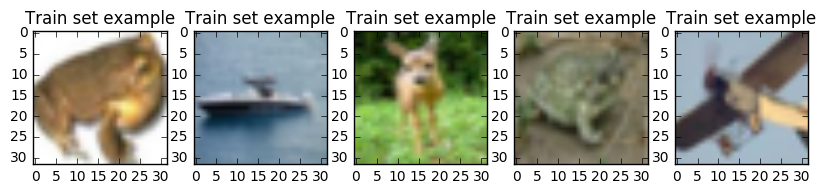

In [285]:
img_size = 32
num_labels = 10
num_channels = 3

merged_labels_np = np.array(merged_labels)
test_labels_np = np.array(test_labels)

# chose to go with this standardization method because it preserves the image colors, but can change it
merged_scaled = merged_data / 255.0
test_data_scaled = test_data / 255.0

# fixed this method to reshape the data correctly and not into meaningless pixels
def reformat(dataset, labels, img_size, num_channels=1):
#     dataset = dataset.reshape((-1, img_size, img_size, num_channels)).astype(np.float32)
    dataset = dataset.reshape((-1, num_channels, img_size, img_size)).astype(np.float32).transpose(0,2,3,1)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(merged_scaled, merged_labels_np, img_size, num_channels)
test_dataset, test_labels_np_onehot = reformat(test_data_scaled, test_labels_np, img_size, num_channels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels_np_onehot.shape)

show_images(5, train_i, train_dataset)

## Keras code for CNN:

In [279]:
subset_size = 50000

# Using the Keras way to translate the labels to one-hot format rather than the section's reformatting method
Y_train = np_utils.to_categorical(merged_labels, num_labels)

train_dataset_subset = train_dataset[:subset_size,:,:,:]
Y_train_subset = Y_train[:subset_size,:]
print('Training subset', train_dataset_subset.shape, Y_train_subset.shape, '\n')

# initialize model and add layers
model = Sequential()
model.add(Convolution2D(1, 3, 3, init='glorot_uniform', activation="relu", border_mode='same', subsample=(2,2),\
                        input_shape=train_dataset_subset.shape[1:], name='name'))
model.add(Flatten())  # need to flatten to get correct input dimensions (2-d) for dense layer
model.add(Dense(num_labels))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.6, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start = time.time()
model.fit(x=train_dataset_subset, y=Y_train_subset, nb_epoch=5, batch_size=256, verbose=0)
predictions = model.predict_classes(test_dataset, batch_size=256)
end = time.time()
correct = (predictions[:,None] == test_labels_np[:,None]).astype(int)
print('\n\nTest set accuracy: {:.2f}%'.format((100.*sum(correct)/len(correct))[0]))
print('Time to run: {:.3f}s'.format(end - start))

Training subset (50000, 32, 32, 3) (50000, 10) 

 9984/10000 [============================>.] - ETA: 0s

Test set accuracy: 10.09%
Time to run: 18.287s


In [280]:
# take a peek at the model's predictions - P=prediction, A=actual
print('P A\n- -')
for i in range(15):
    print(predictions[:,None][i][0], test_labels_np[:,None][i][0])

P A
- -
6 3
6 8
6 8
6 0
6 6
6 6
6 1
6 6
6 3
6 1
6 0
6 9
3 5
3 7
6 9


## ------------------- everything below this line is code from section notebook -------------------

In [106]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [24]:
batch_size = 256

graph = tf.Graph()
with graph.as_default():

    # Input data, with a placeholder to feed the training data at run time.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([img_size*img_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [25]:
num_epochs = 3001
l_array = []

start = time.time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    merged = tf.merge_all_summaries()  
    writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print("Initialized")
    for epoch in range(num_epochs):
        
        offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        l_array.append(l)
        if (epoch % 500 == 0):
            print("Minibatch loss at epoch %d: %f" % (epoch, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels_np))
    test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
end = time.time()
print('Time to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 45.488697
Minibatch accuracy: 10.2%
Minibatch loss at epoch 500: 28.158411
Minibatch accuracy: 11.3%
Minibatch loss at epoch 1000: 34.960449
Minibatch accuracy: 10.5%
Minibatch loss at epoch 1500: 16.663921
Minibatch accuracy: 8.6%
Minibatch loss at epoch 2000: 18.720486
Minibatch accuracy: 11.3%
Minibatch loss at epoch 2500: 28.212635
Minibatch accuracy: 11.7%
Minibatch loss at epoch 3000: 26.702433
Minibatch accuracy: 12.9%
Test accuracy: 0.0%
Time to run: 5.484s


/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


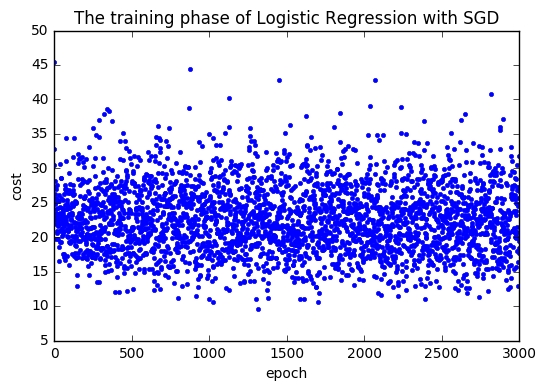

In [26]:
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("The training phase of Logistic Regression with SGD")
plt.show()

In [20]:
def weight_variable(shape):
    #initial = tf.truncated_normal(shape, stddev=0.01)
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)

def bias_variable(shape):
    #initial = tf.constant(0.1, shape=shape)
    initial = tf.zeros(shape)
    return tf.Variable(initial)

split_by_half = lambda x,k : int(x/2**k)

In [21]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([img_size*img_size, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), num_labels])
    layer4_biases = bias_variable([num_labels])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [22]:
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels_np)))
        test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
        test_preds[name] = test_prediction.eval().ravel()

In [23]:
start = time.time()
run_session(1001, "Deep_NN", 0.5)
end = time.time()
print('Time to run: {:.3f}s'.format(end - start))

Initialized
Minibatch loss at epoch 0: 5.658624649047852
Minibatch accuracy: 10.5
Minibatch loss at epoch 500: 3.1608662605285645
Minibatch accuracy: 11.3
Minibatch loss at epoch 1000: 2.8269011974334717
Minibatch accuracy: 8.2


/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Test accuracy: 0.0
